# Figure 2: The spectral plateau disrupts the 1/f power law

In [1]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import mne
import yaml
import numpy as np
import scipy.signal as sig
from fooof import FOOOF
from fooof.sim.gen import gen_aperiodic

from utils import detect_plateau_onset, elec_phys_signal

%load_ext autoreload
%autoreload 2

#### Load params and make directory

In [2]:
yaml_file = open('params.yml')
parsed_yaml_file = yaml.load(yaml_file, Loader=yaml.FullLoader)
globals().update(parsed_yaml_file)

Path(fig_path).mkdir(parents=True, exist_ok=True)

#### Load empirical data of dataset 1

In [3]:
# Load data
data_path = "../data/Fig2/"
fname9 = "subj9_off_R1_raw.fif"
sub9 = mne.io.read_raw_fif(data_path + fname9, preload=True)
sub9.pick_channels(['STN_R01'])  # select channel

# Filter out power line noise
# Important: Keep 50Hz line noise because we fit in that range!
filter_params = {"freqs": np.arange(100, 601, 50),
                 "notch_widths": .5,
                 "method": "spectrum_fit"}
sub9.notch_filter(**filter_params)

# Convert mne to numpy
sample_rate = 2400
start = int(0.5 * sample_rate)  # artefact in beginning of recording
stop = int(185 * sample_rate)  # artefact at the end of recording
sub9 = sub9.get_data(start=start, stop=stop)[0]

# Calc Welch
welch_params = dict(fs=sample_rate, nperseg=sample_rate)
freq, psd_sub9 = sig.welch(sub9, **welch_params)

# Mask above highpass and below lowpass
highpass = 1
lowpass = 600
filt = (freq >= highpass) & (freq <= lowpass)
freq = freq[filt]
psd_sub9 = psd_sub9[filt]

Opening raw data file ../data/Fig2/subj9_off_R1_raw.fif...
Isotrak not found
    Range : 0 ... 482399 =      0.000 ...   201.000 secs
Ready.
Reading 0 ... 482399  =      0.000 ...   201.000 secs...
Removed notch frequencies (Hz):
    100.00 :   39 windows
    150.00 :   39 windows
    200.00 :   39 windows
    250.00 :   39 windows
    300.00 :   39 windows
    350.00 :   39 windows
    400.00 :   39 windows
    450.00 :   39 windows
    500.00 :   39 windows
    550.00 :   39 windows
    600.00 :   39 windows


#### a) Simulate PSD with white noise plateau

In [4]:
# Make 1/f-noise
sim_exponent = 2
aperiodic_params = dict(exponent=sim_exponent, nlv=0.00005, seed=3)
signal_sim, _ = elec_phys_signal(**aperiodic_params)

# Calc PSD
freq, psd_sim = sig.welch(signal_sim, **welch_params)

# Mask above highpass and below lowpass
freq, psd_sim = freq[filt], psd_sim[filt]

# Normalize
psd_sim /= psd_sim[0]

# Detect Noise floor
plateau_onset_sim = detect_plateau_onset(freq, psd_sim, f_start=1)
signal_sim = (freq <= plateau_onset_sim)
plateau_sim = (freq >= plateau_onset_sim)

ground_truth = gen_aperiodic(freq, np.array([0, sim_exponent]))

#### Set plot parameters for a)

In [5]:
# %% Pack lines to plot
plot_sim = (freq[signal_sim], psd_sim[signal_sim], c_sim)  # (x, y, color)
plot_plateau = (freq[plateau_sim], psd_sim[plateau_sim], c_noise)
plot_ground = (freq, 10**ground_truth, c_sim)

# plot limits, ticks, and labels
xlim_a = (1, 600)
y_plateau = psd_sim[freq == xlim_a[1]][0]
ylim_a = (.4*y_plateau, 1)
xticks_a = [1, 10, 50, 100, 200, 600]
ylabel_a = "PSD [a.u.]"
axes_a = dict(xlim=xlim_a, ylim=ylim_a, xticks=xticks_a, xticklabels=xticks_a,
              ylabel=ylabel_a)

# fit for different upper fit limits and plot
plot_fits, dic_fits, vlines = [], [], []

upper_fit_limits = xticks_a[1:-1]
fit_alphas = [.9, 0.6, .4, .2]

fm = FOOOF(verbose=False)
for i, lim in enumerate(upper_fit_limits):
    fm.fit(freq, psd_sim, [1, lim])
    exp = fm.get_params('aperiodic_params', 'exponent')
    fit = gen_aperiodic(fm.freqs, fm.aperiodic_params_)
    label = fr"1-{lim} Hz $\beta=${exp:.2f}"
    plot_fit = fm.freqs, 10**fit, "-"
    dic_fit = dict(c=c_fits[i], lw=2, label=label)

    # annotate x-crossing
    vline = lim, ylim_a[0], 10**fit[-1]
    plot_fits.append(plot_fit)
    dic_fits.append(dic_fit)
    vlines.append(vline)
dic_line = dict(color=c_sim, linestyle=":", lw=.3)

#### Set plot parameters for b)

In [6]:
# Detect Noise floor
plateau_onset_sub9 = detect_plateau_onset(freq, psd_sub9, f_start=1)

# Mask signal/noise
signal_sub9 = (freq <= plateau_onset_sub9)
plateau_sub9 = (freq >= plateau_onset_sub9)

# Pack lines to plot
plot_sub9 = (freq, psd_sub9, c_real)  # (x, y, color)
plot_sub9_signal = (freq[signal_sub9], psd_sub9[signal_sub9], c_real)
plot_sub9_plateau = (freq[plateau_sub9], psd_sub9[plateau_sub9], c_noise)

# Get oscillation coordinates sub9
peak_center_freq1 = 23
peak_center_freq2 = 350

peak_height1 = psd_sub9[freq == peak_center_freq1]
peak_height2 = psd_sub9[freq == peak_center_freq2]

plateau_height = psd_sub9[freq == plateau_onset_sub9]

# Create lines, arrows, and text to annotate noise floor
line_peak1 = dict(x=peak_center_freq1, ymin=plateau_height*0.8,
                  ymax=peak_height1, color=c_sim, linestyle="--", lw=.5)

line_peak2 = dict(x=peak_center_freq2, ymin=plateau_height*0.8,
                  ymax=peak_height2, color=c_sim, linestyle="--", lw=.5)

arrow1 = dict(s="",
              xy=(plateau_onset_sub9, plateau_height*0.8),
              xytext=(peak_center_freq1, plateau_height*0.8),
              arrowprops=dict(arrowstyle="->", color=c_sim, lw=1))
arrow2 = dict(s="",
              xy=(plateau_onset_sub9, plateau_height*0.8),
              xytext=(peak_center_freq2, plateau_height*0.8),
              arrowprops=dict(arrowstyle="->", color=c_sim, lw=1))

plateau_line9 = dict(s="",
                     xy=(plateau_onset_sub9, plateau_height*0.86),
                     xytext=(plateau_onset_sub9, plateau_height*.5),
                     arrowprops=dict(arrowstyle="-", color=c_sim, lw=2))


plateau_txt9 = dict(s=f" {plateau_onset_sub9} Hz",
                    xy=(plateau_onset_sub9, plateau_height*0.7),
                    xytext=(plateau_onset_sub9*1.02, plateau_height*.53))

xticks_b = [1, 10, 100, 600]
xlim_b = (1, 826)
ylim_b = (0.005, 2)
ylabel_b = r"PSD [$\mu$$V^2$/Hz]"

axes_b = dict(xlabel=None, ylabel=ylabel_b, xlim=xlim_b, ylim=ylim_b,
              xticks=xticks_b, xticklabels=xticks_b)

#### Simulate a signal that reproduces the empirical signal of b)

In [7]:
# Set 3 different 1/f-exponents to reproduce psd_sub9
exponent1 = 1
exponent15 = 1.5
exponent2 = 2

peak_params1 = [(3, 0, 1),
                (5, 0, 1),
                (10.5, 4, 3),
                (16, 2, 1.5),
                (23, 15, 5),
                (42, 9, 15),
                (50, .0075, .001),
                (360, 25, 80)]

peak_params15 = [(3, 0, 1),
                 (5, .1, 1),
                 (10.5, 4, 3),
                 (16, 2, 1.5),
                 (23, 15, 5),
                 (42, 15, 22),
                 (50, .0075, .001),
                 (360, 30, 80)]

peak_params2 = [(3, 0.1, .6),
                (5, .3, 1),
                (10.5, 4.1, 3),
                (16, 2.1, 2),
                (23, 14, 5),
                (42, 15, 20),
                (50, .0075, .001),
                (360, 25, 70)]

params1 = dict(exponent=exponent1, periodic_params=peak_params1,
               highpass=True, nlv=.0002)
params15 = dict(exponent=exponent15, periodic_params=peak_params15,
                highpass=True, nlv=.0002)
params2 = dict(exponent=exponent2, periodic_params=peak_params2,
               highpass=True, nlv=.0002)

aperiodic_signal1, full_signal1 = elec_phys_signal(**params1)
aperiodic_signal15, full_signal15 = elec_phys_signal(**params15)
aperiodic_signal2, full_signal2 = elec_phys_signal(**params2)

# Calc Welch
freq, psd_aperiodic1 = sig.welch(aperiodic_signal1, **welch_params)
freq, psd_aperiodic15 = sig.welch(aperiodic_signal15, **welch_params)
freq, psd_aperiodic2 = sig.welch(aperiodic_signal2, **welch_params)
freq, psd_signal1 = sig.welch(full_signal1, **welch_params)
freq, psd_signal15 = sig.welch(full_signal15, **welch_params)
freq, psd_signal2 = sig.welch(full_signal2, **welch_params)

# Filter above highpass and below lowpass
freq = freq[filt]
psd_aperiodic1 = psd_aperiodic1[filt]
psd_aperiodic15 = psd_aperiodic15[filt]
psd_aperiodic2 = psd_aperiodic2[filt]
psd_signal1 = psd_signal1[filt]
psd_signal15 = psd_signal15[filt]
psd_signal2 = psd_signal2[filt]

# Normalize
norm1 = psd_aperiodic1[0] / psd_sub9[0]
norm15 = psd_aperiodic15[0] / psd_sub9[0]
norm2 = psd_aperiodic2[0] / psd_sub9[0]
psd_aperiodic1 /= norm1
psd_signal1 /= norm1
psd_aperiodic15 /= norm15
psd_signal15 /= norm15
psd_aperiodic2 /= norm2
psd_signal2 /= norm2

# Fit fooof
freq_range = [1, 95]  # upper border above oscillations range, below plateau
fooof_params = dict(peak_width_limits=[1, 100], verbose=False)

fm1 = FOOOF(**fooof_params)
fm15 = FOOOF(**fooof_params)
fm2 = FOOOF(**fooof_params)
fm_sub9 = FOOOF(**fooof_params)

fm1.fit(freq, psd_signal1, freq_range)
fm15.fit(freq, psd_signal15, freq_range)
fm2.fit(freq, psd_signal2, freq_range)
fm_sub9.fit(freq, psd_sub9, freq_range)

# Extract fit results
exp1 = fm1.get_params("aperiodic", "exponent")
exp15 = fm15.get_params("aperiodic", "exponent")
exp2 = fm2.get_params("aperiodic", "exponent")
exp_sub9 = fm_sub9.get_params('aperiodic_params', 'exponent')
off_sub9 = fm_sub9.get_params('aperiodic_params', 'offset')

# Simulate fitting results
ap_fit1 = gen_aperiodic(fm1.freqs, fm1.aperiodic_params_)
ap_fit15 = gen_aperiodic(fm15.freqs, fm15.aperiodic_params_)
ap_fit2 = gen_aperiodic(fm2.freqs, fm2.aperiodic_params_)
ap_fit_sub9 = gen_aperiodic(fm_sub9.freqs, fm_sub9.aperiodic_params_)

fit1 = fm1.freqs, 10**ap_fit1, c_low
fit15 = fm15.freqs, 10**ap_fit15, c_med
fit2 = fm2.freqs, 10**ap_fit2, c_high
fit_sub9 = fm_sub9.freqs, 10**ap_fit_sub9, c_real

psd_plateau_fits = [fit1, fit15, fit2]

spec9_fit_label = fr"FOOOF LFP $\beta=${exp_sub9:.2f}"

#### Set plot parameters for c)

In [8]:
plot_sub9 = (freq, psd_sub9, c_real)
plot_signal1 = (freq, psd_signal1, c_low)
plot_signal15 = (freq, psd_signal15, c_med)
plot_signal2 = (freq, psd_signal2, c_high)

# Summarize
psd_plateau_vary = [plot_signal1, plot_signal15, plot_signal2]
plot_plateau1 = (freq, psd_aperiodic1, c_ground)
plot_plateau15 = (freq, psd_aperiodic15, c_ground)
plot_plateau2 = (freq, psd_aperiodic2, c_ground)

xlim_c = (1, 825)
xlabel_c = "Frequency in Hz"

# Summarize
plateau_labels = [r"$\beta_{fit}$="f"{exp1:.2f}",
                  r"$\beta_{fit}$="f"{exp15:.2f}",
                  r"$\beta_{fit}$="f"{exp2:.2f}"]
plateau_labels = [fr"FOOOF flat $\beta=${exp1:.2f}",
                  fr"FOOOF med $\beta=${exp15:.2f}",
                  fr"FOOOF steep $\beta=${exp2:.2f}"]
psd_aperiodic_vary = [plot_plateau1, plot_plateau15, plot_plateau2]

labelpad = 5
leg_c = dict(ncol=3, loc=10, bbox_to_anchor=(.54, .4))
axes_c = dict(xticks=xticks_b, xticklabels=xticks_b, xlim=xlim_c)


freq_mask_fill_area = (freq > 1) & (freq <= freq_range[1])
freqs_fill = freq[freq_mask_fill_area]
plot_delta_low = (freqs_fill, psd_aperiodic1[freq_mask_fill_area],
                  10**ap_fit1[fm1.freqs > 1])
plot_delta_med = (freqs_fill, psd_aperiodic15[freq_mask_fill_area],
                  10**ap_fit15[fm1.freqs > 1])
plot_delta_high = (freqs_fill, psd_aperiodic2[freq_mask_fill_area],
                   10**ap_fit2[fm1.freqs > 1])

# Summarize
delta_power = [plot_delta_low, plot_delta_med, plot_delta_high]
colors_c = [c_low, c_med, c_high]

#### Plot settings

In [9]:
# Mpl settings
mpl.rcParams['xtick.labelsize'] = legend_fontsize
mpl.rcParams['ytick.labelsize'] = legend_fontsize
mpl.rcParams['axes.labelsize'] = legend_fontsize
mpl.rcParams['legend.fontsize'] = legend_fontsize
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

panel_labels = dict(x=0, y=1.01, fontsize=panel_fontsize,
                    fontdict=dict(fontweight="bold"))

line_fit = dict(lw=2, ls=":", zorder=5)
line_ground = dict(lw=.5, ls="--", zorder=5)
psd_aperiodic_kwargs = dict(lw=0.5)

# Figure 2

/var/folders/07/j2k588bn66nddqtk3lsg4sgr0000gp/T/ipykernel_14408/2866645233.py:114: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(fig_path + "Fig2.pdf", bbox_inches="tight")
/var/folders/07/j2k588bn66nddqtk3lsg4sgr0000gp/T/ipykernel_14408/2866645233.py:115: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(fig_path + "Fig2.png", dpi=1000, bbox_inches="tight")
/opt/anaconda3/envs/one-over-f/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


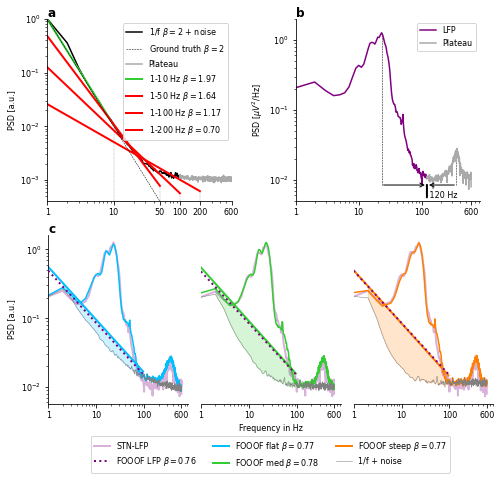

In [12]:
# Prepare Gridspec
fig = plt.figure(figsize=[fig_width, 6.5], constrained_layout=True)
gs0 = gridspec.GridSpec(3, 1, figure=fig, height_ratios=[6, 6, 1])

# a) and b) gridspec
gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])
ax1 = fig.add_subplot(gs00[0])
ax2 = fig.add_subplot(gs00[1])

# c) gridspec
gs01 = gs0[1].subgridspec(1, 3)
ax3 = fig.add_subplot(gs01[0])
ax4 = fig.add_subplot(gs01[1])
ax5 = fig.add_subplot(gs01[2])

c_axes = [ax3, ax4, ax5]

# Legend suplot
gs02 = gs0[2]
ax_leg = fig.add_subplot(gs02)
ax_leg.axis("off")


# a)
ax = ax1

# Plot simulated PSD and ground truth
ax.loglog(*plot_sim, label=fr"1/f $\beta=${sim_exponent} + noise")
ax.loglog(*plot_ground, **line_ground,
          label=fr"Ground truth $\beta=${sim_exponent}")
ax.loglog(*plot_plateau, label="Plateau")

# Plot fits for different upper fitting borders
for i in range(len(upper_fit_limits)):
    ax.loglog(*plot_fits[i], **dic_fits[i])
    ax.vlines(*vlines[i], **dic_line)

# Set axes
ax.set(**axes_a)
ax.legend()
ax.text(s="a", **panel_labels, transform=ax.transAxes)


# b)
ax = ax2

# Plot Sub 9
ax.loglog(*plot_sub9_signal, label="LFP")
ax.loglog(*plot_sub9_plateau, label="Plateau")

# Plot Peak lines
ax.vlines(**line_peak1)
ax.vlines(**line_peak2)

# Plot Arrow left and right
ax.annotate(**arrow1)
ax.annotate(**arrow2)

# Annotate plateau start
ax.annotate(**plateau_line9)
ax.annotate(**plateau_txt9, fontsize=legend_fontsize)

# Set axes
ax.set(**axes_b)
ax.legend(loc=0)
ax.text(s="b", **panel_labels, transform=ax.transAxes)


# c)
# Make sure we have just one label for each repetitive plot
spec9_label = ["STN-LFP", None, None]
spec9_fit_labels = [spec9_fit_label, None, None]
aperiodic_label = [None, None, "1/f + noise"]

for i, ax in enumerate(c_axes):

    # Plot LFP and fooof fit
    ax.loglog(*plot_sub9, alpha=0.3, lw=2, label=spec9_label[i])
    ax.loglog(*fit_sub9, **line_fit, label=spec9_fit_labels[i])

    # Plot sim low delta power and fooof fit
    ax.loglog(*psd_plateau_vary[i])
    ax.loglog(*psd_plateau_fits[i], lw=2, label=plateau_labels[i])

    # Plot aperiodic component of sim
    ax.loglog(*psd_aperiodic_vary[i], **psd_aperiodic_kwargs,
              label=aperiodic_label[i])

    # Indicate delta power as fill between aperiodic component
    # and full spectrum
    ax.fill_between(*delta_power[i], color=colors_c[i], alpha=0.2)

    # Draw arrow
    if i == 1:
        ax.set_xlabel(xlabel_c)

    # Save legend and set axes
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        ax.set_ylabel(ylabel_a, labelpad=labelpad)
        ax.text(s="c", **panel_labels, transform=ax.transAxes)
    else:
        hands, labs = ax.get_legend_handles_labels()
        handles.extend(hands)
        labels.extend(labs)
        ax.spines["left"].set_visible(False)
        ax.set_yticks([], minor=True)
        ax.set_yticks([])
    ax.set(**axes_c)

# Set legend between subplots
leg = ax_leg.legend(handles, labels, **leg_c)

plt.savefig(fig_path + "Fig2.pdf", bbox_inches="tight")
plt.savefig(fig_path + "Fig2.png", dpi=1000, bbox_inches="tight")
plt.show()